In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to train an CNN + LSTM model

In [2]:
import warnings
import gc
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.backend import clear_session

from src.pipeline_transformers import ColumnDropperTransformer

# Load Data

In [3]:
nrows = None
X_train = pd.read_csv("data/transformed/X_train.csv", nrows=nrows)
X_val = pd.read_csv("data/transformed/X_val.csv", nrows=nrows)
X_test = pd.read_csv("data/transformed/X_test.csv", nrows=nrows)

y_train = pd.read_csv("data/transformed/y_train.csv", nrows=nrows)
y_val = pd.read_csv("data/transformed/y_val.csv", nrows=nrows)
y_test = pd.read_csv("data/transformed/y_test.csv", nrows=nrows)

display(X_val.tail())
display(y_val.tail())

,user_id,timestamp,x,y,z
199293,25,8688572339000,10.53,14.90,14.90
199294,25,8688622327000,3.17,15.70,15.70
199295,25,8688672346000,-1.04,15.79,15.79
199296,25,8688722333000,6.13,10.23,10.23
199297,25,8688772321000,0.08,9.23,9.23


,activity
199293,Jogging
199294,Jogging
199295,Jogging
199296,Jogging
199297,Jogging


# Define Parameters

In [4]:
timesteps = 80 # length of each sequence
steps = 20 # step size between sequences
n_features = 3 
n_classes = len(y_train["activity"].unique().tolist())

# Preprocess

In [5]:
# normalize the data and convert back to dataframe
columns = X_train.columns

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

# label encode the target variable
encoder = LabelEncoder()
y_train = pd.DataFrame(encoder.fit_transform(y_train), columns=["activity"])
y_val = pd.DataFrame(encoder.transform(y_val), columns=["activity"])
y_test = pd.DataFrame(encoder.transform(y_test), columns=["activity"])

# save the scaler and encoder using joblib
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(encoder, "models/encoder.pkl")

/Users/ani/Projects/4_sequence_classification_using_LSTM_CNN/.4_venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ani/Projects/4_sequence_classification_using_LSTM_CNN/.4_venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/ani/Projects/4_sequence_classification_using_LSTM_CNN/.4_venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.clas

['models/encoder.pkl']

In [6]:
encoder.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [7]:
def preprocess_data(X: pd.DataFrame, y: pd.DataFrame, n_timesteps: int = 80, steps: int = 40):
    """
    Preprocess data for LSTM model.
    """

    # merge X and y on index
    data = X.merge(y, left_index=True, right_index=True)
    
    # select chunks of 240 timestamps with a step of 40 for each user and activity
    chunks = []
    activity = []
    for index, df in data.groupby(['user_id', 'activity']):
        # select chunks of 240 timestamps with a step of 40
        for i in range(0, len(df), steps):
            chunk = df[i:i+n_timesteps]
            if len(chunk) == n_timesteps:
                chunks.append(chunk[['x', 'y', 'z']].values.reshape(1, n_timesteps, 3))
                activity.append(df['activity'].values[0])

    X = np.concatenate(chunks, axis=0)
    y = np.array(activity)

    return X, y

In [8]:
X_train, y_train = preprocess_data(X_train, y_train, timesteps, steps)
X_val, y_val = preprocess_data(X_val, y_val, timesteps, steps)
X_test, y_test = preprocess_data(X_test, y_test, timesteps, steps)

In [9]:
print(f'{X_train.shape=}')
print(f'{y_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_val.shape=}')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

X_train.shape=(31225, 80, 3)
y_train.shape=(31225,)
X_val.shape=(9870, 80, 3)
y_val.shape=(9870,)
X_test.shape=(13181, 80, 3)
y_test.shape=(13181,)


# Hyper-parameter Tuning

In [19]:
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes accuracy on the validation set.'''
    clear_session()

    # define early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=10)

    # define model architecture
    model = Sequential()

    model.add(Conv1D(filters=trial.suggest_categorical("filters", [128, 128*2, 128*3, 128*4, 128*5]), kernel_size=3, activation='relu', input_shape=(timesteps,n_features)))

    model.add(Dropout(trial.suggest_uniform("dropout", 0.0, 0.5)))

    model.add(MaxPooling1D(pool_size=2))

    model.add(Bidirectional(
            LSTM(
                units=trial.suggest_categorical("units", [128, 128*2, 128*3, 128*4, 128*5]),
                input_shape=(timesteps, n_features))))
    
    model.add(Dropout(trial.suggest_uniform("dropout", 0.0, 0.5)))
    
    model.add(Dense(units=trial.suggest_categorical("units", [128, 128*2, 128*3, 128*4, 128*5]), activation='relu'))

    model.add(Dense(n_classes, activation='softmax'))

    # compile model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='adam',
        metrics=["sparse_categorical_accuracy"])
    
    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=trial.suggest_categorical("batch_size", [32, 32*2, 32*3, 32*4, 32*5]),
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[early_stop],
        verbose=False,
    )

    # compute validation error
    score = model.evaluate(X_val, y_val, verbose=0)
    
    return score[0]

In [20]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction="minimize", study_name="cnn_lstm")
study.optimize(objective, n_trials=5)

[I 2023-04-05 10:41:35,501] A new study created in memory with name: cnn_lstm
[I 2023-04-05 11:01:22,413] Trial 0 finished with value: 0.9614128470420837 and parameters: {'filters': 384, 'dropout': 0.46472857831907277, 'units': 640, 'batch_size': 128}. Best is trial 0 with value: 0.9614128470420837.
[I 2023-04-05 11:13:26,548] Trial 1 finished with value: 1.0091973543167114 and parameters: {'filters': 640, 'dropout': 0.047027480429370216, 'units': 256, 'batch_size': 64}. Best is trial 0 with value: 0.9614128470420837.
[I 2023-04-05 11:25:15,799] Trial 2 finished with value: 0.7426249384880066 and parameters: {'filters': 512, 'dropout': 0.11430266654183957, 'units': 384, 'batch_size': 128}. Best is trial 2 with value: 0.7426249384880066.
[I 2023-04-05 11:30:54,432] Trial 3 finished with value: 0.9566682577133179 and parameters: {'filters': 384, 'dropout': 0.3736637276918887, 'units': 256, 'batch_size': 128}. Best is trial 2 with value: 0.7426249384880066.
[I 2023-04-05 11:35:30,998] Tri

In [21]:
# print best parameters
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'filters': 512, 'dropout': 0.11430266654183957, 'units': 384, 'batch_size': 128}


# Fit model with best parameters

In [22]:
units = best_params['units']
dropout = best_params['dropout']
filters = best_params['filters']
batch_size = best_params['batch_size']

In [23]:
clear_session()
# define early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

# define model architecture
best_model = Sequential()

best_model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(timesteps,n_features)))

best_model.add(Dropout(dropout))

best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Bidirectional(
        LSTM(
            units=units,
            input_shape=(timesteps, n_features))))

best_model.add(Dropout(dropout))

best_model.add(Dense(units=units))

best_model.add(Dense(n_classes, activation='softmax'))

# compile model
best_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=["sparse_categorical_accuracy"])

# fit model
best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stop],
    verbose=False,
)

<Axes: >

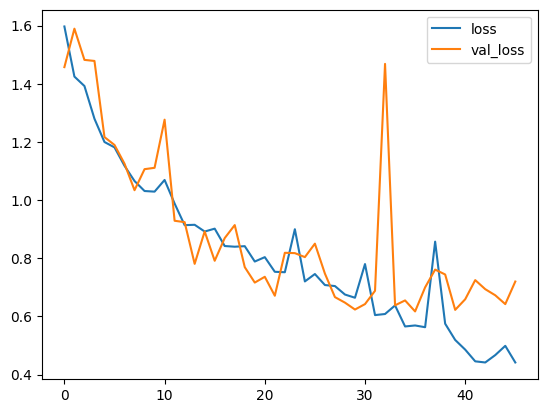

In [24]:
losses = pd.DataFrame(best_model.history.history)
losses[['loss', 'val_loss']].plot()

<Axes: >

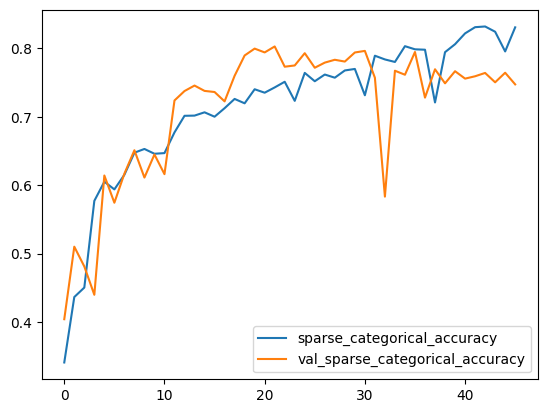

In [25]:
accuracy = pd.DataFrame(best_model.history.history)
accuracy[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [26]:
# Evaluate the model accuracy on the test set.
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.7119024991989136 / Test accuracy: 0.7625370025634766


# Save Predictions & model

In [23]:
# save the model using joblib
joblib.dump(best_model, "models/cnn_lstm.pkl")

INFO:tensorflow:Assets written to: ram://4f9b1fa4-bf02-489a-ae9b-8d454f19f958/assets


INFO:tensorflow:Assets written to: ram://4f9b1fa4-bf02-489a-ae9b-8d454f19f958/assets


['models/cnn_lstm.pkl']

In [24]:
# save predictions
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = pd.DataFrame(y_pred, columns=["predicted_activity"])
y_pred.to_csv("predictions/predictions_cnn_lstm.csv", index=False)

412/412 [==============================] - 7s 15ms/step


In [25]:
y_pred.value_counts()

predicted_activity
1                     4367
5                     4177
4                     1906
0                     1541
3                      769
2                      421
dtype: int64

In [27]:
pd.DataFrame(y_test).value_counts()

5    4548
1    4227
4    2026
0    1392
2     531
3     457
dtype: int64

In [29]:
pd.DataFrame(y_val).value_counts()

5    3987
1    2871
2    1113
4     749
0     589
3     561
dtype: int64

In [ ]:
# https://link.springer.com/article/10.1007/s11370-021-00358-7 (CNN + LSTM)
# https://ieeexplore.ieee.org/document/7881728 (CNN)
# https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81
# user mcnemars test to compare models